In [2]:
import torch.nn as nn
from torch.functional import F
import torch
from diffusion.Model import *
from torch.nn import init
import numpy as np


# Lista de afazeres 
* Funções de difusão funcionais
* Arquiteturas da rede Funcionais
    * Unet 
    * Unet ++
    * Unet +++
    * Bloco de rede dinamica para testes de desempenho
    * Arquitetura com metodo de treino dinamico
    * treinar sem classificador
    * Gerar duas arquiteturas 
        * Unet de geração de imagem com redes dinamicas
        * Unet de realce de imagem com redes estaticas
* Codigo de carregamento de parametros
* Codigo de treinamento
* Codigo de calculo das loss functions 
* Codigo de calculo das metricas
* Subir no wandb 
* Fazer script de combnacao de datasets

* treino da nova arquitetura de difusão no cluster com dados paralelilzados
* estudar sobre o Sampler para diffusao, Time embedding, Residual Layer, Transformer layers, Convolutioinal layeres necessarias
    * Posso fazer tres versoes com quantidades diferentes de camadas de layers
    * como a rede cospe uma imagem posso usar funcoes prontas para controlar o treinamento e plocar os resultados diretamente(minhas principais duvidas)
    * Outra duvida minha e como usar o no classifier guidance com as camadas dinamicas, terei de ser criativo pois esse passo persiste na inferencia

### Models for image generation with diffusion

## Unet

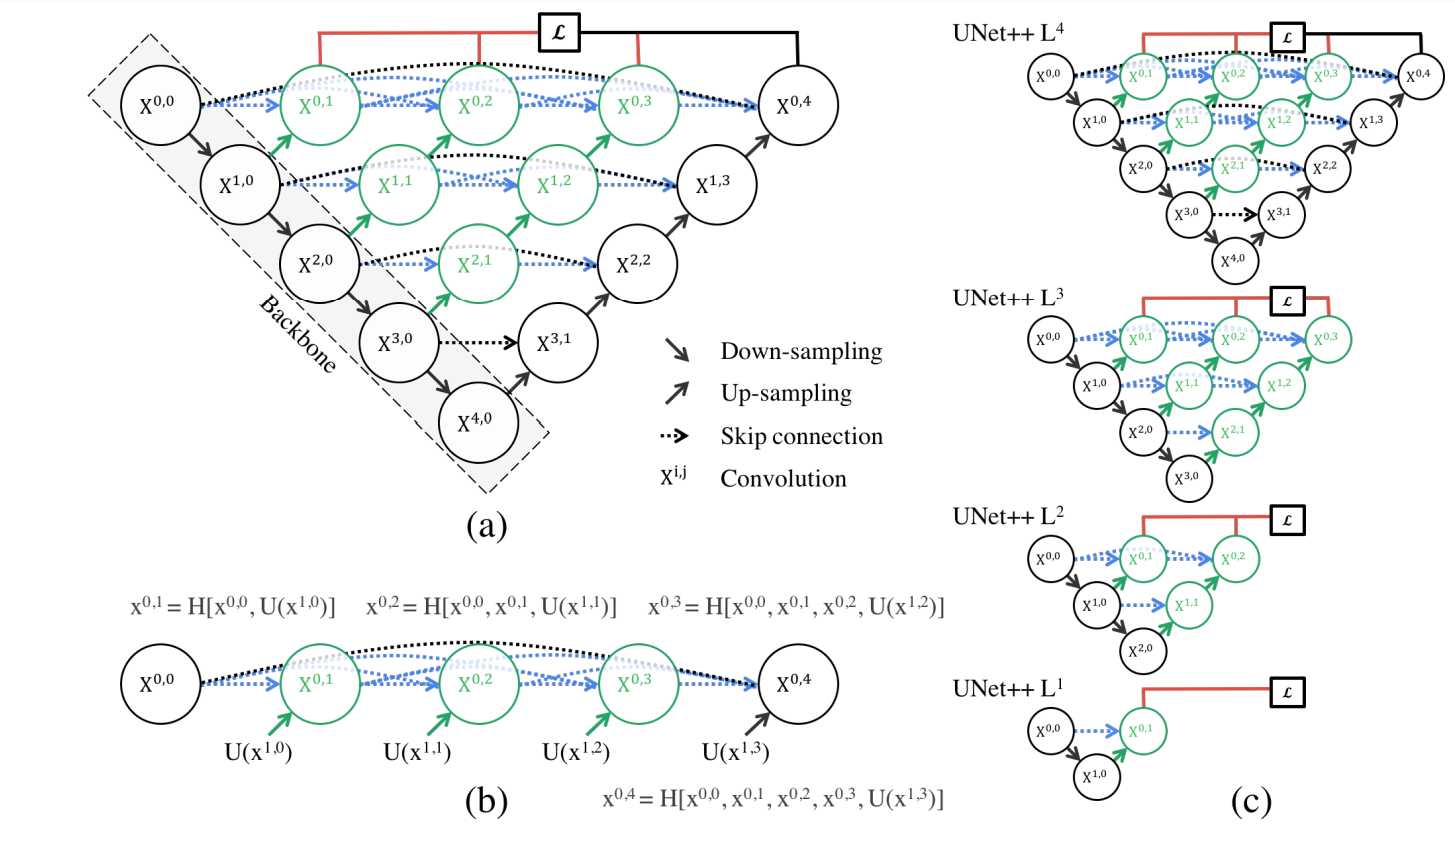

Observações: Usar a inicialização de tensores init xavier. 

## UNET++


### Time Embedding

Os cálculos realizados antes da criação do embedding de tempo podem ser representados pela seguinte equação:

$  \text{emb}_{ij} = \begin{cases} 
\sin\left(\frac{i}{10000^{\frac{2j}{d_{\text{model}}}}}\right) & \text{se } j \text{ é par} \\
\cos\left(\frac{i}{10000^{\frac{2(j-1)}{d_{\text{model}}}}}\right) & \text{se } j \text{ é ímpar}
\end{cases}  $

onde:
- \( i \) varia de 0 a \( $T-1$ \) (número de passos de tempo)
- \( j \) varia de 0 a \( $d_{\text{model}}-1$ \) (dimensão do modelo)
- \( $d_{\text{model}}$ \) é a dimensão do modelo
- \( T \) é o número de passos de tempo

Esta equação descreve como os valores de seno e cosseno são calculados para cada posição \( i \) e dimensão \( j \) do embedding.

In [2]:
class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(num_groups=min(32, in_ch), num_channels=in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape

        # Normalização
        h = self.group_norm(x)

        # Projeções Q, K, V
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        # Ajusta formato para multiplicação matricial
        q = q.permute(0, 2, 3, 1).view(B, H * W, C)  # (B, H*W, C)
        k = k.view(B, C, H * W)  # (B, C, H*W)
        w = torch.bmm(q, k) * (C ** -0.5)  # (B, H*W, H*W)
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)  # (B, H*W, C)
        h = torch.bmm(w, v)  # (B, H*W, C)
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)  # Volta para (B, C, H, W)

        # Projeção final e residual
        h = self.proj(h)

        return x + h

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels, tdim, dropout, attn=False):
        """
        Bloco residual especial para o upsampling que garante o ajuste correto dos canais.
        """
        super(ResBlockUp, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.tdim = tdim

        # Camada para ajustar canais se necessário
        self.channel_adjust = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1) 
            if in_channels != out_channels else None
        )

        # Camadas de convolução e normalização para o bloco residual
        self.block1 = nn.Sequential(
            #nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.block2 = nn.Sequential(
            #nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )

        # Projeção do time embedding (t)
        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(tdim, out_channels)
        )

        # Atenção opcional
        self.attn = nn.MultiheadAttention(out_channels, num_heads=8) if attn else nn.Identity()

    def forward(self, x, temb):
        # Ajustar canais se necessário
        h = x
        if self.channel_adjust:
            x = self.channel_adjust(x)

        # Aplicar o primeiro bloco convolucional
        h = self.block1(h)

        # Adicionar time embedding ao tensor
        temb_out = self.time_proj(temb).view(temb.size(0), -1, 1, 1)
        h = h + temb_out

        # Aplicar o segundo bloco convolucional
        h = self.block2(h)

        # Aplicar atenção, se habilitada
        if self.attn:
            h = self.attn(h)

        # Soma residual
        return h + x

class _ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn, num_groups=None):
        super().__init__()
        self.tdim=tdim
        self.out_ch = out_ch
        # Ajusta num_groups dinamicamente mudei de 32 para 64
        
        # Ajustar dinamicamente o número de grupos para ser um divisor de in_ch e out_ch
        if num_groups is None or in_ch % num_groups != 0 or out_ch % num_groups != 0:
            num_groups = min(32, min(in_ch, out_ch))  # Escolhe o menor divisor adequado # Ajusta dinamicamente o num_groups

        assert in_ch % num_groups == 0, f"in_ch ({in_ch}) deve ser divisível por num_groups ({num_groups})"
        assert out_ch % num_groups == 0, f"out_ch ({out_ch}) deve ser divisível por num_groups ({num_groups})"

        self.block1 = nn.Sequential(
            nn.GroupNorm(num_groups, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(num_groups, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        #####

        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        
        self.shortcut = (
            nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
            if in_ch != out_ch
            else nn.Identity()
        )
        self.attn = nn.MultiheadAttention(out_ch, num_heads=8) if attn else nn.Identity()
        
        #self.attn = AttnBlock(out_ch) if attn else nn.Identity()

        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):    
        if x.device != temb.device:
                raise ValueError("Input and time embedding must be on the same device.")
        #print(f"[ResBlock] Input shape: {x.shape}, temb {temb.shape} tdim {self.tdim}, out_ch {self.out_ch}")
        h = self.block1(x)
        #print(f"[ResBlock] After block1: {h.shape}, temb {temb.shape} tdim {self.tdim}, out_ch {self.out_ch}/n")
        
        # Ajustar o formato de temb antes da projeção
        temb = temb.view(temb.size(0), -1)  # Garantir forma [batch_size, tdim]
        temb_proj = self.temb_proj(temb)  # Aplicar projeção linear
        #print(f"[ResBlock] After block1: {h.shape}, temb {temb.shape} tdim {self.tdim}, out_ch {self.out_ch}/n")

        temb_proj = temb_proj[:, :, None, None]  # Expansão para [batch_size, out_ch, 1, 1]
        h = self.block2(h)
        #print(f"[ResBlock] Output shape: {h.shape}")
        h = h + self.shortcut(x)
    
        #print(f"[ResBlock] Output shape: {h.shape}")

        # Bloco de atenção, se configurado
        if isinstance(self.attn, nn.MultiheadAttention):  # Apenas aplica atenção se for MultiheadAttention
            
            # Ajusta para formato 3D (seq_len, batch_size, embed_dim)
            batch, channels, height, width = h.shape
            h_reshaped = h.view(batch, channels, -1).permute(2, 0, 1)  # (seq_len, batch, channels)

            # Aplica atenção
            h_attn, _ = self.attn(h_reshaped, h_reshaped, h_reshaped)

            # Volta para formato 4D (batch_size, channels, height, width)
            h = h_attn.permute(1, 2, 0).view(batch, channels, height, width)
            #h =  h + self.res_conv(x)
        else: 
            h = self.attn(h)
        return h




NameError: name 'nn' is not defined

In [3]:
# class UNetPlusPlus(nn.Module):
#     def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
#         super(UNetPlusPlus, self).__init__()
#         self.T = T
#         self.ch = ch
#         self.ch_mult = ch_mult
#         self.attn = attn
#         self.num_res_blocks = num_res_blocks
#         self.dropout = dropout
#         assert all([i < len(ch_mult) for i in attn]), "Índice de atenção fora do limite."

#         # Time embedding
#         tdim = ch * 4
#         self.time_embedding = TimeEmbedding(T, ch, tdim)

#         # Head (entrada inicial)
#         self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)

#         # Downsampling e upsampling
#         self.downblocks, chs_down = self._make_downblocks(ch, ch_mult, attn, num_res_blocks, dropout, tdim)
#         self.upblocks = self._make_upblocks(ch, ch_mult, attn, num_res_blocks, dropout, chs_down.copy(), tdim)

#         # Middle blocks (gargalo)
#         self.middle_blocks = nn.ModuleList([
#             ResBlock(ch * ch_mult[-1], ch * ch_mult[-1], tdim, dropout, attn=False)
#         ])
#         # Tail (saída final)
#         self.tail = nn.Conv2d(ch, 3, kernel_size=3, stride=1, padding=1)


#     def _make_downblocks(self, ch, ch_mult, attn, num_res_blocks, dropout, tdim):
#         """
#         Cria os blocos de downsampling, cada um composto de várias camadas ResBlock e uma conexão residual.
#         """
#         downblocks = nn.ModuleList()
#         chs_down = []
#         now_ch = ch

#         for i, mult in enumerate(ch_mult):
#             out_ch = ch * mult
#             print(out_ch)
#             chs_down.append(now_ch)  # Salva os canais antes do downsampling
#             res_blocks = nn.ModuleList([
#                 ResBlock(now_ch if j == 0 else out_ch, out_ch, tdim=tdim, dropout=dropout, attn=(i in attn))
#                 for j in range(num_res_blocks)
#             ])
#             downblocks.append(res_blocks)
#             now_ch = out_ch

#         return downblocks, chs_down
#     def _make_upblocks(self, ch, ch_mult, attn, num_res_blocks, dropout, chs_down, tdim):
#         upblocks = nn.ModuleList()
#         now_ch = ch * ch_mult[-1]  # Começa com o número de canais do último bloco de downsampling

#         for i, mult in reversed(list(enumerate(ch_mult))):
#             skip_ch = chs_down.pop()  # Canais da "skip connection" do downsampling
#             out_ch = ch * mult  # Canais do bloco atual
#             in_ch = now_ch + skip_ch  # Combinação dos canais atuais e da "skip connection"

#             # Certifique-se de ajustar os canais para evitar incompatibilidade
#             res_blocks = nn.ModuleList([
#                 ResBlockUp(in_ch if j == 0 else out_ch, out_ch, tdim=tdim, dropout=dropout, attn=(i in attn))
#                 for j in range(num_res_blocks)
#             ])
#             upblocks.append(res_blocks)

#             now_ch = out_ch  # Atualiza o número de canais atuais

#         return upblocks
#     # def _make_upblocks(self, ch, ch_mult, attn, num_res_blocks, dropout, chs_down, tdim):
#     #     upblocks = nn.ModuleList()
#     #     now_ch = ch * ch_mult[-1]  # Começa com o número de canais do último bloco de downsampling

#     #     for i, mult in reversed(list(enumerate(ch_mult))):
#     #         skip_ch = chs_down.pop()  # Canais da "skip connection" do downsampling
#     #         out_ch = ch * mult  # Canais do bloco atual
#     #         in_ch = now_ch + skip_ch  # Combinação dos canais atuais e da "skip connection"

#     #         # Certifique-se de ajustar os canais para evitar incompatibilidade
#     #         res_blocks = nn.ModuleList([
#     #             ResBlock(in_ch if j == 0 else out_ch, out_ch, tdim=tdim, dropout=dropout, attn=(i in attn))
#     #             for j in range(num_res_blocks)
#     #         ])
#     #         upblocks.append(res_blocks)

#     #         now_ch = out_ch  # Atualiza o número de canais atuais

#     #     return upblocks

#     # def forward(self, x, t):
#     #     print(f"[UNetPlusPlus] Input shape: {x.shape}")
#     #     t = self.time_embedding(t)  # Projeta o timestep

#     #     # Head
#     #     h = self.head(x)
#     #     print(f"[UNetPlusPlus] After head: {h.shape}")

#     #     # Downsampling
#     #     skip_connections = []
#     #     for i, res_blocks in enumerate(self.downblocks):
#     #         for res_block in res_blocks:
#     #             h = res_block(h, t)
#     #         skip_connections.append(h)  # Salva a saída para "skip connection"
#     #         h = F.avg_pool2d(h, kernel_size=2)  # Downsample
#     #         print(f"[UNetPlusPlus] After downsampling stage {i}: {h.shape}")

#     #     # Middle Blocks
#     #     for block in self.middle_blocks:
#     #         h = block(h, t)
#     #         print(f"[UNetPlusPlus] After middle block: {h.shape}")

#     #    # Upsampling
#     #     for i, res_blocks in enumerate(self.upblocks):
#     #         h = F.interpolate(h, scale_factor=2, mode="nearest")  # Upsample
#     #         skip = skip_connections.pop()
            
#     #         # Ajuste das dimensões espaciais antes da concatenação
#     #         if h.shape[2:] != skip.shape[2:]:
#     #             diff_h = h.shape[2] - skip.shape[2]
#     #             diff_w = h.shape[3] - skip.shape[3]
#     #             skip = F.pad(skip, (diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2))
#     #         print(f"[UNetPlusPlus] Upsampled shape: {h.shape}, skip shape: {skip.shape}")
#     #         # Ajustar o número de canais para corresponder antes da concatenação
#     #         if h.shape[1] != skip.shape[1]:
#     #             skip = nn.Conv2d(skip.shape[1], x.shape[1], kernel_size=1)(skip)

#     #         h = torch.cat([h, skip], dim=1)  # Concat skip connections
#     #         print(f"[UNetPlusPlus] After concat: {h.shape}, t.shape: {t.shape}")
#     #         for res_block in res_blocks:
#     #             h = res_block(h, t)
#     #         print(f"[UNetPlusPlus] After upsampling stage {i}: {h.shape}")


#     #     # Tail
#     #     h = self.tail(h)
#     #     print(f"[UNetPlusPlus] Output shape: {h.shape}")

#     #     return h
#     def forward(self, x, t):
#         print(f"[UNetPlusPlus] Input shape: {x.shape}")
#         t = self.time_embedding(t)  # Projeta o timestep

#         # Head
#         h = self.head(x)
#         print(f"[UNetPlusPlus] After head: {h.shape}")

#         # Downsampling
#         skip_connections = []
#         for i, res_blocks in enumerate(self.downblocks):
#             for res_block in res_blocks:
#                 h = res_block(h, t)
#             skip_connections.append(h)  # Salva a saída para "skip connection"
#             h = F.avg_pool2d(h, kernel_size=2)  # Downsample
#             print(f"[UNetPlusPlus] After downsampling stage {i}: {h.shape}")

#         # Middle Blocks
#         for block in self.middle_blocks:
#             h = block(h, t)
#             print(f"[UNetPlusPlus] After middle block: {h.shape}")

#         # Upsampling
#         for i, res_blocks in enumerate(self.upblocks):
#             h = F.interpolate(h, scale_factor=2, mode="nearest")  # Upsample
#             skip = skip_connections.pop()
            
#             # Ajuste das dimensões espaciais antes da concatenação
#             if h.shape[2:] != skip.shape[2:]:
#                 diff_h = h.shape[2] - skip.shape[2]
#                 diff_w = h.shape[3] - skip.shape[3]
#                 skip = F.pad(skip, (diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2))
#             print(f"[UNetPlusPlus] Upsampled shape: {h.shape}, skip shape: {skip.shape}")
            
#             # Ajustar o número de canais da skip connection para corresponder ao input do resblock
#             if h.shape[1] != skip.shape[1]:
#                 skip = nn.Conv2d(skip.shape[1], h.shape[1], kernel_size=1).to(h.device)(skip)

#             h = torch.cat([h, skip], dim=1)  # Concat skip connections
#             print(f"[UNetPlusPlus] After concat: {h.shape}, t.shape: {t.shape}")
#             for res_block in res_blocks:
#                 h = res_block(h, t)
#             print(f"[UNetPlusPlus] After upsampling stage {i}: {h.shape}")

#         # Tail
#         h = self.tail(h)
#         print(f"[UNetPlusPlus] Output shape: {h.shape}")

#         return h



In [4]:
# T = 1000
# ch = 64
# ch_mult = [1, 2, 2, 2]
# attn = [1, 2]  # Índices dos níveis com atenção
# num_res_blocks = 2
# dropout = 0.1

# model = UNetPlusPlus(T, ch, ch_mult, attn, num_res_blocks, dropout)

# x = torch.randn(1, 3, 256, 256)  # Exemplo de entrada
# t = torch.randint(0, T, (1,))  # Exemplo de timestep
# output = model(x, t)  # Forward pass
# print(f"Output shape: {output.shape}")

## Unet Dynamica

In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=True):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.cond_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )

        self.attn = nn.MultiheadAttention(out_ch, num_heads=8) if attn else nn.Identity()

        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, temb, cemb=None):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        if cemb is not None:
            h += self.cond_proj(cemb)[:, :, None, None]
        h = self.block2(h)
        h = h + self.shortcut(x)
        
        if isinstance(self.attn, nn.MultiheadAttention):
            batch, channels, height, width = h.shape
            h_reshaped = h.view(batch, channels, -1).permute(2, 0, 1)  # (seq_len, batch, channels)
            h_attn, _ = self.attn(h_reshaped, h_reshaped, h_reshaped)
            h = h_attn.permute(1, 2, 0).view(batch, channels, height, width)
        else:
            h = self.attn(h)
        return h
    
    
    # def forward(self, x, temb, labels):
    #     h = self.block1(x)
    #     h += self.temb_proj(temb)[:, :, None, None]
    #     h += self.cond_proj(labels)[:, :, None, None]
    #     h = self.block2(h)

    #     h = h + self.shortcut(x)
    #     # Bloco de atenção, se configurado
    #     if isinstance(self.attn, nn.MultiheadAttention):  # Apenas aplica atenção se for MultiheadAttention
            
    #         # Ajusta para formato 3D (seq_len, batch_size, embed_dim)
    #         batch, channels, height, width = h.shape
    #         h_reshaped = h.view(batch, channels, -1).permute(2, 0, 1)  # (seq_len, batch, channels)

    #         # Aplica atenção
    #         h_attn, _ = self.attn(h_reshaped, h_reshaped, h_reshaped)

    #         # Volta para formato 4D (batch_size, channels, height, width)
    #         h = h_attn.permute(1, 2, 0).view(batch, channels, height, width)
    #         #h =  h + self.res_conv(x)
    #     else: 
    #         h = self.attn(h)
    #     return h

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from DiffusionFreeGuidence import TimeEmbedding, ConditionalEmbedding, DownSample, UpSample, Swish

class DynamicUNet_0(nn.Module):
    def __init__(self, T, num_labels, ch, ch_mult, num_res_blocks, dropout, attn):
        super().__init__()
        self.attn = attn
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)
        self.cond_embedding = ConditionalEmbedding(num_labels, ch, tdim)

        ## Layers 
        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks, self.chs, self.now_ch = self.create_downblocks(ch, ch_mult, num_res_blocks, tdim, dropout)
        self.middleblocks = self.create_middleblocks(self.now_ch, tdim, dropout)
        self.upblocks = self.create_upblocks(ch, ch_mult, num_res_blocks, tdim, dropout)
        
        self.tail = nn.Sequential(
            nn.GroupNorm(32, 128),
            Swish(),
            nn.Conv2d(self.now_ch, 3, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)


    def create_downblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        downblocks = nn.ModuleList()
        chs = [ch]
        now_ch = ch

        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                downblocks.append(ResBlock(in_ch=now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout,attn=False))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                downblocks.append(DownSample(now_ch))
                chs.append(now_ch)
        print("now channel", chs)
        return downblocks, chs, now_ch

    def create_middleblocks(self, now_ch, tdim, dropout):
        return nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),# Subaquatic
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False), # Atmospheric
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),# Subaquatic
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),# Atmospheric
        ])

    def create_upblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        upblocks = nn.ModuleList()
        chs = self.chs.copy()
        now_ch = self.now_ch

        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                upblocks.append(ResBlock(in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout, attn=False))
                now_ch = out_ch
            if i != 0:
                upblocks.append(UpSample(now_ch))
        print('Now_ch', chs)
        assert len(chs) == 0
        return upblocks

    def dynamic_forward(self, x, t, labels):
        """
        Dynamic forward pass based on input image type.
        x: input image tensor
        t: timestep embedding tensor
        labels: conditional labels tensor
        """
        # Determine image type using statistical thresholding on color channels
        red_channel_mean = x[:, 0, :, :].mean()  # Mean of red channel
        blue_channel_mean = x[:, 2, :, :].mean()  # Mean of blue channel

        # Activate subaquatic layers if red < blue; otherwise, activate atmospheric layers
        is_subaquatic = blue_channel_mean > red_channel_mean

        for i, layer in enumerate(self.middleblocks):
            if is_subaquatic:
                if i % 2 == 0:  # Enable subaquatic layers (even-indexed)
                    for param in layer.parameters():
                        param.requires_grad = True
                else:  # Freeze atmospheric layers (odd-indexed)
                    for param in layer.parameters():
                        param.requires_grad = False
            else:
                if i % 2 != 0:  # Enable atmospheric layers (odd-indexed)
                    for param in layer.parameters():
                        param.requires_grad = True
                else:  # Freeze subaquatic layers (even-indexed)
                    for param in layer.parameters():
                        param.requires_grad = False
    def forward(self, x, t, labels):
        # Ajuste dinâmico dos middleblocks com base no tipo de entrada
        self.dynamic_forward(x, t, labels)

        # Timestep embedding
        temb = self.time_embedding(t)
        cemb = self.cond_embedding(labels)
        
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb, cemb)  # Passando os argumentos corretos
            hs.append(h)

        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb, cemb)  # Passando os argumentos corretos

        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb, cemb)  # Passando os argumentos corretos
        
        print(f"Input tail Block{h.shape}")

        h = self.tail(h)
        #assert len(hs) == 0
        return h



In [7]:
import torch
import torch.nn as nn
import torch.nn.init as init
from DiffusionFreeGuidence import TimeEmbedding, ConditionalEmbedding, DownSample, UpSample, Swish, ResBlock


class DynamicUNet(nn.Module):
    def __init__(self, T, num_labels, ch, ch_mult, num_res_blocks, dropout, attn):
        super().__init__()
        self.attn = attn
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)
        self.cond_embedding = ConditionalEmbedding(num_labels, ch, tdim)

        ## Layers
        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks, self.chs, self.now_ch = self.create_downblocks(ch, ch_mult, num_res_blocks, tdim, dropout)
        self.middleblocks = self.create_middleblocks(self.now_ch, tdim, dropout)
        self.upblocks = self.create_upblocks(ch, ch_mult, num_res_blocks, tdim, dropout)

        self.tail = nn.Sequential(
            nn.GroupNorm(32, ch),
            Swish(),
            nn.Conv2d(ch, 3, kernel_size=3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def create_downblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        downblocks = nn.ModuleList()
        chs = [ch]
        now_ch = ch

        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                downblocks.append(ResBlock(in_ch=now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout, attn=self.attn))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                downblocks.append(DownSample(now_ch))
                chs.append(now_ch)
        return downblocks, chs, now_ch

    def create_middleblocks(self, now_ch, tdim, dropout):
        return nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False)
        ])

    def create_upblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        upblocks = nn.ModuleList()
        chs = self.chs.copy()
        now_ch = self.now_ch

        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                upblocks.append(ResBlock(in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout, attn=self.attn))
                now_ch = out_ch
            if i != 0:
                upblocks.append(UpSample(now_ch))
        return upblocks

    def forward(self, x, t, labels):
        temb = self.time_embedding(t)
        cemb = self.cond_embedding(labels)

        # Downsampling
        h = self.head(x)
        hs = [h]  # Armazena saída inicial
        for layer in self.downblocks:
            h = layer(h, temb, cemb)
            hs.append(h)  # Salva a saída de cada camada

        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb, cemb)

        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                # Garante que sempre existe um tensor para concatenar
                assert len(hs) > 0, "A lista `hs` está vazia antes do esperado."

                # Remove o último tensor de `hs` e ajusta o tamanho, se necessário
                skip_h = hs.pop()
                if h.shape[2:] != skip_h.shape[2:]:
                    skip_h = F.interpolate(skip_h, size=h.shape[2:], mode="nearest")

                h = torch.cat([h, skip_h], dim=1)
            h = layer(h, temb, cemb)

        # # Garantia final
        # print(f"Elementos restantes em hs: {len(hs)}")
        # assert len(hs) == 0, f"A lista `hs` contém {len(hs)} elementos restantes no final do Upsampling."

        return self.tail(h)



In [1]:
%pip install torchviz
%pip install torchsummary


Note: you may need to restart the kernel to use updated packages.
  Using cached torchsummary-1.5.1-py3-none-any.whl.metadata (296 bytes)
Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
from torchviz import make_dot
from torchsummary import summary


# Teste do modelo
if __name__ == "__main__":
    T = 1000
    num_labels = 2 # ultimo ponto faltando da investigacao
    ch = 128
    ch_mult = [1, 2, 2, 2]
    num_res_blocks = 2
    dropout = 0.1
    attn = False

    model = DynamicUNet(T, num_labels, ch, ch_mult, num_res_blocks, dropout, attn)#.to("cuda")

    batch_size = 1
    image_size = 256
    x = torch.randn(batch_size, 3, image_size, image_size)#.to("cuda")  # Imagens de entrada
    t = torch.randint(0, T, size=(batch_size,))#.to("cuda")  # Timestep aleatório
    labels = torch.randint(0, num_labels, size=(batch_size,))#.to("cuda")  # Rótulos aleatórios

    y = model(x, t, labels)  # Passagem no modelo
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")

    # # Gere o gráfico do modelo
    # dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

    # # Salve a imagem no diretório atual
    # dot.format = 'png'
    # dot.render('model_architecture')

    # print("A imagem da arquitetura do modelo foi salva como 'model_architecture.png'.")

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
A imagem da arquitetura do modelo foi salva como 'model_architecture.png'.


In [10]:
import torch
from torchsummary import summary

# Defina a classe DynamicUNet aqui ou importe-a se estiver em outro arquivo
# from your_module import DynamicUNet
class DynamicUNet(nn.Module):
    def __init__(self, T, num_labels, ch, ch_mult, num_res_blocks, dropout, attn):
        super().__init__()
        self.attn = attn
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)
        self.cond_embedding = ConditionalEmbedding(num_labels, ch, tdim)

        ## Layers
        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks, self.chs, self.now_ch = self.create_downblocks(ch, ch_mult, num_res_blocks, tdim, dropout)
        self.middleblocks = self.create_middleblocks(self.now_ch, tdim, dropout)
        self.upblocks = self.create_upblocks(ch, ch_mult, num_res_blocks, tdim, dropout)

        self.tail = nn.Sequential(
            nn.GroupNorm(32, ch),
            Swish(),
            nn.Conv2d(ch, 3, kernel_size=3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def create_downblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        downblocks = nn.ModuleList()
        chs = [ch]
        now_ch = ch

        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                downblocks.append(ResBlock(in_ch=now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout, attn=self.attn))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                downblocks.append(DownSample(now_ch))
                chs.append(now_ch)
        return downblocks, chs, now_ch

    def create_middleblocks(self, now_ch, tdim, dropout):
        return nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False)
        ])

    def create_upblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        upblocks = nn.ModuleList()
        chs = self.chs.copy()
        now_ch = self.now_ch

        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                upblocks.append(ResBlock(in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout, attn=self.attn))
                now_ch = out_ch
            if i != 0:
                upblocks.append(UpSample(now_ch))
        return upblocks

    def forward(self, x, t, labels):
        temb = self.time_embedding(t)
        cemb = self.cond_embedding(labels)

        # Downsampling
        h = self.head(x)
        print(f"Head: {h.shape}")
        hs = [h]  # Armazena saída inicial
        for layer in self.downblocks:
            h = layer(h, temb, cemb)
            print(f"Downblock: {h.shape}")
            hs.append(h)  # Salva a saída de cada camada

        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb, cemb)
            print(f"Middleblock: {h.shape}")

        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                # Garante que sempre existe um tensor para concatenar
                assert len(hs) > 0, "A lista `hs` está vazia antes do esperado."

                # Remove o último tensor de `hs` e ajusta o tamanho, se necessário
                skip_h = hs.pop()
                if h.shape[2:] != skip_h.shape[2:]:
                    skip_h = F.interpolate(skip_h, size=h.shape[2:], mode="nearest")

                h = torch.cat([h, skip_h], dim=1)
            h = layer(h, temb, cemb)
            print(f"Upblock: {h.shape}")

        # # Garantia final
        # print(f"Elementos restantes em hs: {len(hs)}")
        # assert len(hs) == 0, f"A lista `hs` contém {len(hs)} elementos restantes no final do Upsampling."

        output = self.tail(h)
        print(f"Tail: {output.shape}")
        return output
if __name__ == "__main__":
    T = 1000
    num_labels = 2 # ultimo ponto faltando da investigacao
    ch = 128
    ch_mult = [1, 2, 2, 2]
    num_res_blocks = 2
    dropout = 0.1
    attn = False

    model = DynamicUNet(T, num_labels, ch, ch_mult, num_res_blocks, dropout, attn)

    batch_size = 1
    image_size = 256
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    model.to(device)

    x = torch.randn(batch_size, 3, image_size, image_size).to(device)  # Imagens de entrada
    t = torch.randint(0, T, size=(batch_size,)).long().to(device)  # Timestep aleatório
    labels = torch.randint(0, num_labels, size=(batch_size,)).long().to(device)  # Rótulos aleatórios

    y = model(x, t, labels)  # Passagem no modelo
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")



Head: torch.Size([1, 128, 256, 256])
Downblock: torch.Size([1, 128, 256, 256])
Downblock: torch.Size([1, 128, 256, 256])
Downblock: torch.Size([1, 128, 128, 128])
Downblock: torch.Size([1, 256, 128, 128])
Downblock: torch.Size([1, 256, 128, 128])
Downblock: torch.Size([1, 256, 64, 64])
Downblock: torch.Size([1, 256, 64, 64])
Downblock: torch.Size([1, 256, 64, 64])
Downblock: torch.Size([1, 256, 32, 32])
Downblock: torch.Size([1, 256, 32, 32])
Downblock: torch.Size([1, 256, 32, 32])
Middleblock: torch.Size([1, 256, 32, 32])
Middleblock: torch.Size([1, 256, 32, 32])
Middleblock: torch.Size([1, 256, 32, 32])
Middleblock: torch.Size([1, 256, 32, 32])
Upblock: torch.Size([1, 256, 32, 32])
Upblock: torch.Size([1, 256, 32, 32])
Upblock: torch.Size([1, 256, 64, 64])
Upblock: torch.Size([1, 256, 64, 64])
Upblock: torch.Size([1, 256, 64, 64])
Upblock: torch.Size([1, 256, 128, 128])
Upblock: torch.Size([1, 256, 128, 128])
Upblock: torch.Size([1, 256, 128, 128])
Upblock: torch.Size([1, 256, 256, 2

##  Teste de funções modulares para modelos de difusão

Testar:
* Scheduller[Feito]
* Noise [Feito]
* Prediction [Em andamento]
* No Classifier Guidance 
    * Ajustar com os Datasets[Feito] (Funciona melhor para datasets com dados anotados)
* Treino
    * Uso dos datasets [Feito]
    * rotinas de treinamento percorrendo os dois datastes[Em andamento]
    * Uso dinamico das funcoes de perda
    * Uso dinamico dos dados anotados

* Teste
    * Gerenciar treinamento usando SSIM e PSNR para o primeiro treino de caracteristicas
    * Gerenciar treinamento de realce, usando lpips, FID, UIQM, UCIQE, alem do psnr e ssim
* Validação
    *  Metricas
    * Utilizar as mesmas metricas do teste, porem usando os conjuntos de validacao passados pela rede
* Models 
    * Unet Dynamica[Feito](Usado para cores, evita um classificador)
    * Unet normal[Cancelado]
    * Unet ++[Cancelado]
    * Unet +++[Cancelado]



# Difusao


# Geração de imagem e aprendizado de caracteristicas
Aprendizado não supervisionado pela rede nos datasets, funções de perda perceptuais e estruturais.


**Posso fazer as duas redes se treinar, salvar o checkpoint, adionar as loss e novos dados e continuar treinando**

# Realce de Imagem 
Novas Funções de perda para realce de cor e detalhes na imagem e dados anotados

# Teste de Escalas das funcoes de perda

In [1]:
import torch 
import torch.nn as nn
from Loss.loss import *
import time

from kornia.losses import ssim_loss as ssim, psnr_loss as psnr, MS_SSIMLoss as ms_ssim, charbonnier_loss as charbonnier

x =  torch.randn(1, 3, 256, 256)
y = torch.randn(1, 3, 256, 256)

## Teste de Amplitude para definir os pesos das loss functions
ch = CharbonnierLoss()
dino = PerceptualLoss_dino()
vgg = PerceptualLoss_vgg()
msssim = MSSSIMLoss()
col =angular_color_loss() 

loss = [ch, dino, vgg, msssim, col]


print("Losses");start_time = time.time()
print(f"Charbonnier loss {charbonnier(x,y).mean().item()}")
end_time = time.time()
print(f"Time {end_time - start_time}")

start_time = time.time()
print(f"Perceptual Vgg {ch(x,y).mean().item()}")
end_time = time.time()
print(f"Time {end_time - start_time}")

# start_time = time.time()
# print(f"Perceptual DINO {dino(x,y)}")
# end_time = time.time()
# print(f"Time {end_time - start_time}")

# start_time = time.time()
# print(f"MSSSIM {msssim(x,y).mean().item()}")
# end_time = time.time()
# print(f"Time {end_time - start_time}")

start_time = time.time()
print(f"color {col(x,y).mean().item()}")
end_time = time.time()
print(f"Time {end_time - start_time}")





Using cache found in /home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main
/home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Losses
Charbonnier loss 0.6070065498352051
Time 0.0007927417755126953
Perceptual Vgg 0.6070065498352051
Time 0.00020194053649902344
color 1.00437331199646
Time 0.021602153778076172


In [3]:
import torch.nn.functional as F
def crop_tensor(tensor):
    """
    Realiza um crop de um tensor de tamanho (1, 3, 256, 256) para (1, 3, 252, 252).
    
    Parâmetros:
        tensor (torch.Tensor): Tensor no formato (1, 3, 256, 256).
    
    Retorna:
        torch.Tensor: Tensor cropped no formato (1, 3, 252, 252).
    """
    # Calcula os índices para o corte
    crop_size = 252
    start = (256 - crop_size) // 2  # Começo do corte
    end = start + crop_size         # Fim do corte

    #tensor  = tensor.to("cuda")
    
    # Aplica o corte diretamente
    cropped_tensor = F.pad(tensor, pad=(-start, -start, -start, -start))
    print(f"Input shape: {tensor.shape}, Output shape: {cropped_tensor.shape}")
    
    return cropped_tensor
dino = PerceptualLoss_dino(version="dinov2",model="dinov2_vits14")

msssim = MSSSIMLoss()
#cropped_tensor = crop_tensor(x);cropped_tensor_2 = crop_tensor(y)
start_time = time.time()
print(f"Perceptual DINO {dino(x,y)}") #posso fazer um crop para o tamanho da imagem. De forma que seja possivel utilizar o patch size 14. Nese caso 256/14 = 18 
end_time = time.time()
print(f"Time {end_time - start_time}")


Using cache found in /home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main


Perceptual DINO 28.416542053222656
Time 0.1567833423614502


In [9]:
from kornia.losses import ssim_loss as ssim, psnr_loss as psnr, MS_SSIMLoss as ms_ssim, charbonnier_loss as charbonnier
import time
import torch
from Loss.loss import MSSSIMLoss
#ms_ssim = MSSSIMLoss()
ms_ssim = ms_ssim()
x = torch.randn(1, 3, 256, 256)
y = torch.randn(1, 3, 256, 256)

start_time = time.time()
print(f"MSSSIM {ms_ssim(x,y)}")
end_time = time.time()
print(f"Time {end_time - start_time}")

MSSSIM 215.025390625
Time 5.434581279754639


### Esccala das funcoes de perda

In [1]:
import torch 
import torch.nn as nn
from Loss.loss import *
import time

from kornia.losses import ssim_loss as ssim, psnr_loss as psnr, MS_SSIMLoss as ms_ssim, charbonnier_loss as charbonnier

x =  torch.randn(8, 3, 256, 256,device="cuda")
y = torch.randn(8, 3, 256, 256, device="cuda")

## Teste de Amplitude para definir os pesos das loss functions
ch = CharbonnierLoss()
dino = PerceptualLoss_dino().to("cuda")
vgg = PerceptualLoss_vgg()
msssim = MSSSIMLoss().to("cuda")
col =angular_color_loss() 

loss = [ch, dino, vgg, msssim, col]


print("Losses");start_time = time.time()
print(f"    Charbonnier loss {charbonnier(x,y).mean().item()}")
end_time = time.time()
print(f"        Time {end_time - start_time}")

start_time = time.time()
print(f"    Perceptual Vgg {ch(x,y).mean().item()}")
end_time = time.time()
print(f"        Time {end_time - start_time}")

start_time = time.time()
print(f"    Perceptual DINO {dino(x,y)}")
end_time = time.time()
print(f"        Time {end_time - start_time}")

start_time = time.time()
print(f"    MSSSIM {msssim(x,y).mean().item()}")
end_time = time.time()
print(f"        Time {end_time - start_time}")

start_time = time.time()
print(f"    color {col(x,y).mean().item()}")
end_time = time.time()
print(f"        Time {end_time - start_time}")

Using cache found in /home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main
/home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/pdi_4/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Losses
    Charbonnier loss 0.6051008701324463
        Time 0.03132224082946777
    Perceptual Vgg 0.6051008701324463
        Time 0.0001850128173828125
    Perceptual DINO 28.094608306884766
        Time 0.17861461639404297
    MSSSIM 215.24407958984375
        Time 0.057959556579589844
    color 1.0004668235778809
        Time 0.025110960006713867


Aqui está a nova sugestão de **pesos** ajustados para as combinações de perdas especificadas: 

1. **Perceptual DINO + MSSSIM**
2. **Perceptual VGG + Charbonnier**
3. **Charbonnier + MSSIM + Color Charbonnier**

Os pesos foram balanceados com base na escala das saídas das perdas mencionadas.

---

### **Cálculos e Sugestões de Pesos**

#### 1. **Perceptual DINO + MSSSIM**
- **Perceptual DINO**: Valor médio: `27.9183`
- **MSSSIM**: Valor médio: `215.0199`

A relação entre as magnitudes é:
\[
$\frac{\text{MSSSIM}}{\text{DINO}} = \frac{215.0199}{27.9183} \approx 7.7$
\]

Para equilibrar as contribuições:
\[
$\text{Peso Perceptual DINO} = 1.0,\quad \text{Peso MSSSIM} = \frac{1}{7.7} \approx 0.13$
\]

**Pesos sugeridos para a combinação Perceptual DINO + MSSSIM**:
```python
weights_comb_1 = {
    "perceptual_dino": 1.0,
    "msssim": 0.13,
}
```

---

#### 2. **Perceptual VGG + Charbonnier**
- **Perceptual VGG**: Valor médio: `0.6045`
- **Charbonnier**: Valor médio: `0.6045`

Ambas as perdas têm magnitudes similares, então podemos atribuir os mesmos pesos.

**Pesos sugeridos para a combinação Perceptual VGG + Charbonnier**:
```python
weights_comb_2 = {
    "perceptual_vgg": 1.0,
    "charbonnier": 1.0,
}
```

---

#### 3. **Charbonnier + MSSIM + Color Charbonnier**
- **Charbonnier**: Valor médio: `0.6045`
- **MSSIM**: Valor médio: `215.0199`
- **Color Charbonnier**: Valor médio: `0.9997`

A relação entre as magnitudes é:
\[
$\frac{\text{MSSIM}}{\text{Charbonnier}} = \frac{215.0199}{0.6045} \approx 355.6$
\]
\[
$\frac{\text{Color Charbonnier}}{\text{Charbonnier}} = \frac{0.9997}{0.6045} \approx 1.65$
\]

Para equilibrar as perdas:
\[
$\text{Peso Charbonnier} = 1.0,\quad 
\text{Peso MSSIM} = \frac{1}{355.6} \approx 0.0028,\quad
\text{Peso Color Charbonnier} = \frac{1}{1.65} \approx 0.61$
\]

**Pesos sugeridos para a combinação Charbonnier + MSSIM + Color Charbonnier**:
```python
weights_comb_3 = {
    "charbonnier": 1.0,
    "mssim": 0.0028,
    "color_charbonnier": 0.61,
}
```

---

### Resumo Final dos Pesos Sugeridos

1. **Perceptual DINO + MSSSIM**
   ```python
   weights_comb_1 = {
       "perceptual_dino": 1.0,
       "msssim": 0.13,
   }
   ```

2. **Perceptual VGG + Charbonnier**
   ```python
   weights_comb_2 = {
       "perceptual_vgg": 1.0,
       "charbonnier": 1.0,
   }
   ```

3. **Charbonnier + MSSIM + Color Charbonnier**
   ```python
   weights_comb_3 = {
       "charbonnier": 1.0,
       "mssim": 0.0028,
       "color_charbonnier": 0.61,
   }
   ```

---

### Explicação
- **Foco no equilíbrio**: Os pesos foram atribuídos considerando a magnitude das saídas das funções de perda, de forma que todas contribuam de maneira proporcional ao processo de otimização.
- **Normalização relativa**: Quando as perdas estão em escalas similares (como Perceptual VGG e Charbonnier), os pesos foram mantidos iguais.
- **Perdas dominantes**: Para perdas com valores muito maiores (MSSIM, Perceptual DINO), os pesos foram ajustados para que não dominem o treinamento.

Se precisar de mais ajustes ou explicações, é só falar! 🚀

# Metrics


In [4]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Lambda, ToTensor
from scipy.linalg import sqrtm

class FID:
    def __init__(self, device="cpu"):
        self.device = device
        self.model = inception_v3(pretrained=True, transform_input=False).to(device)
        self.model.fc = nn.Identity()  # Remove a última camada de classificação
        self.model.eval()

        self.transform = Compose([
            Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy()),  # Converte para formato HWC
            #Lambda(lambda x: np.clip((x * 255).astype(np.uint8), 0, 255)),  # Converte imagens HWC para x-RGB Uint FLAV
            ToTensor()  # Converte de volta para torch.Tensor
        ])
    def _calculate_stats(self, features):
        mean = np.mean(features, axis=0)
        cov = np.cov(features, rowvar=False)
        return mean, cov

    # def _frechet_distance(self, mu1, sigma1, mu2, sigma2):
    #     diff = mu1 - mu2
    #     covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

    #     # Caso de matriz não positiva definida
    #     if not np.isfinite(covmean).all():
    #         offset = np.eye(sigma1.shape[0]) * 1e-6
    #         covmean = sqrtm((sigma1 + offset) @ (sigma2 + offset))

    #     return np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    def _frechet_distance(self, mu1, sigma1, mu2, sigma2):
        diff = mu1 - mu2
        covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

        # Caso de matriz não positiva definida
        if not np.isfinite(covmean).all() or np.iscomplexobj(covmean):
            offset = np.eye(sigma1.shape[0]) * 1e-6
            covmean = sqrtm((sigma1 + offset) @ (sigma2 + offset))

        # Certifique-se de que o resultado seja real
        covmean = covmean.real

        return np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)


    def extract_features(self, images):
        with torch.no_grad():
            features = self.model(images).cpu().numpy()
        return features

    def compute_fid(self, real_images, generated_images):
        """
        Calcula o FID entre as imagens reais e geradas.

        Args:
            real_images (torch.Tensor): Batch de imagens reais (N, C, H, W)
            generated_images (torch.Tensor): Batch de imagens geradas (N, C, H, W)

        Returns:
            float: valor do FID
        """
        # Normalizar e redimensionar
        real_images = torch.stack([self.transform(img) for img in real_images]).to(self.device)
        generated_images = torch.stack([self.transform(img) for img in generated_images]).to(self.device)

        # Extrair features
        real_features = self.extract_features(real_images)
        generated_features = self.extract_features(generated_images)

        # Calcular estatísticas
        mu1, sigma1 = self._calculate_stats(real_features)
        mu2, sigma2 = self._calculate_stats(generated_features)

        # Calcular FID
        fid = self._frechet_distance(mu1, sigma1, mu2, sigma2)
        return fid

# Exemplo de uso
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fid_calculator = FID(device=device)

    # Exemplo com dados aleatórios (substitua com seus próprios dados)
    real_images = torch.rand(10, 3, 256, 256)  # Batch de imagens reais
    generated_images = torch.rand(10, 3, 256, 256)  # Batch de imagens geradas
    generated_images = real_images

    fid_score = fid_calculator.compute_fid(real_images, generated_images)
    print(f"FID: {fid_score}")

FID: -0.004096000491245552


In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from utils.utils import Atmospheric_Dataset, Underwater_Dataset
from utils.rotinas import *
from diffusion.Model import DynamicUNet

# Configurações gerais
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Transforms para garantir três canais
custom_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Carregando datasets Atmospheric e Underwater
atmospheric_dataset = Atmospheric_Dataset(
    atmospheric_dataset_name="HDR+",
    transforms=custom_transform,
    task="train",
    supervised=True
)

underwater_dataset = Underwater_Dataset(
    underwater_dataset_name="HICRD",
    transforms=custom_transform,
    task="train",
    supervised=True
)

# Loaders
atmospheric_loader = DataLoader(atmospheric_dataset, batch_size=1, shuffle=True)
underwater_loader = DataLoader(underwater_dataset, batch_size=1, shuffle=True)

# Instanciando o modelo
model = DynamicUNet(
    T=1000,
    ch=64,
    ch_mult=[1, 2, 2],
    num_res_blocks=2,
    dropout=0.1,
    attn=True
).to(device)

# Loss e otimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Função de teste
def test_model(loader, label, num_batches=1):
    model.eval()
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches:
                break
            images = images.to(device)
            timesteps = torch.randint(0, 1000, (images.size(0),)).to(device)
            labels = torch.tensor([label] * images.size(0)).to(device)
            outputs = model(images, timesteps, labels, context_zero=False)
            print(f"Batch {i+1}/{num_batches} - Outputs shape: {outputs.shape}")

# Treinando brevemente
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(atmospheric_loader):
        images = images.to(device)
        labels = labels.to(device)
        timesteps = torch.randint(0, 1000, (images.size(0),)).to(device)
        #labels = torch.tensor([1] * images.size(0)).to(device)  # Atmospheric label
        
        optimizer.zero_grad()
        outputs = model(images, timesteps, labels, context_zero=False)
        loss = criterion(outputs, images)  # Reconstrução simples como teste
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f"Epoch {epoch+1}, Step {i}, Loss: {loss.item():.4f}")

# Testando no dataset Atmospheric
print("Testando no dataset Atmospheric...")
test_model(atmospheric_loader, label=1)

# Testando no dataset Underwater
print("Testando no dataset Underwater...")
test_model(underwater_loader, label=0)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x128 and 256x256)

Atmospheric batch shape: torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256])
Underwater batch shape: torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256])


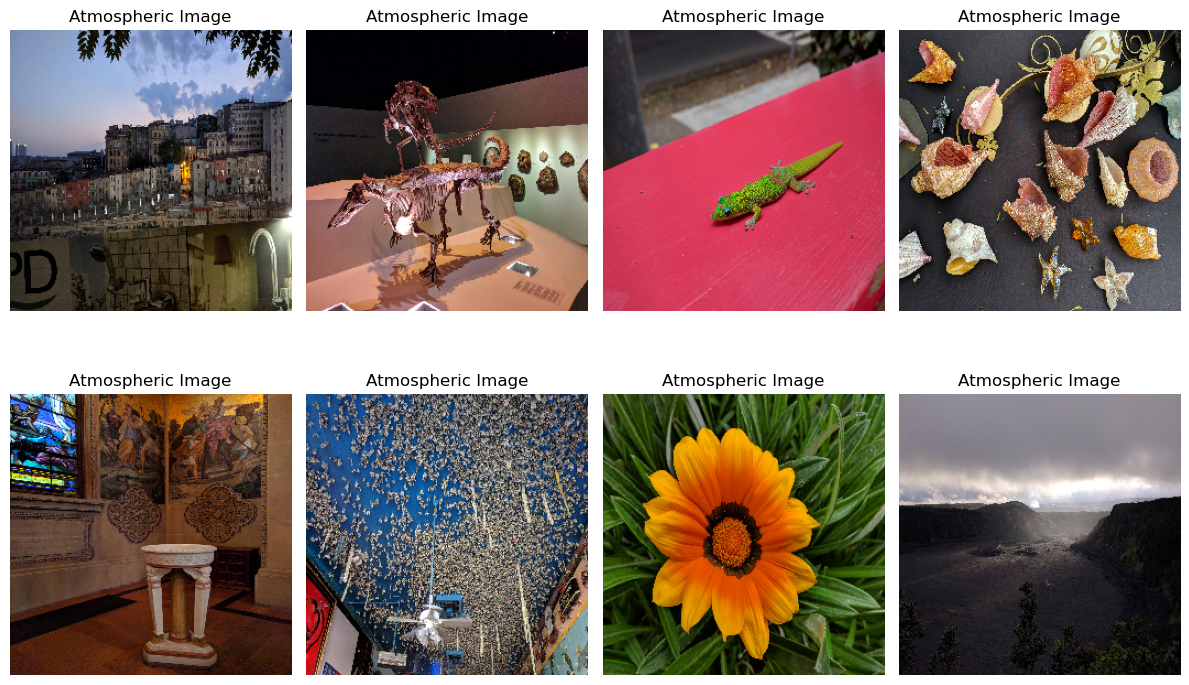

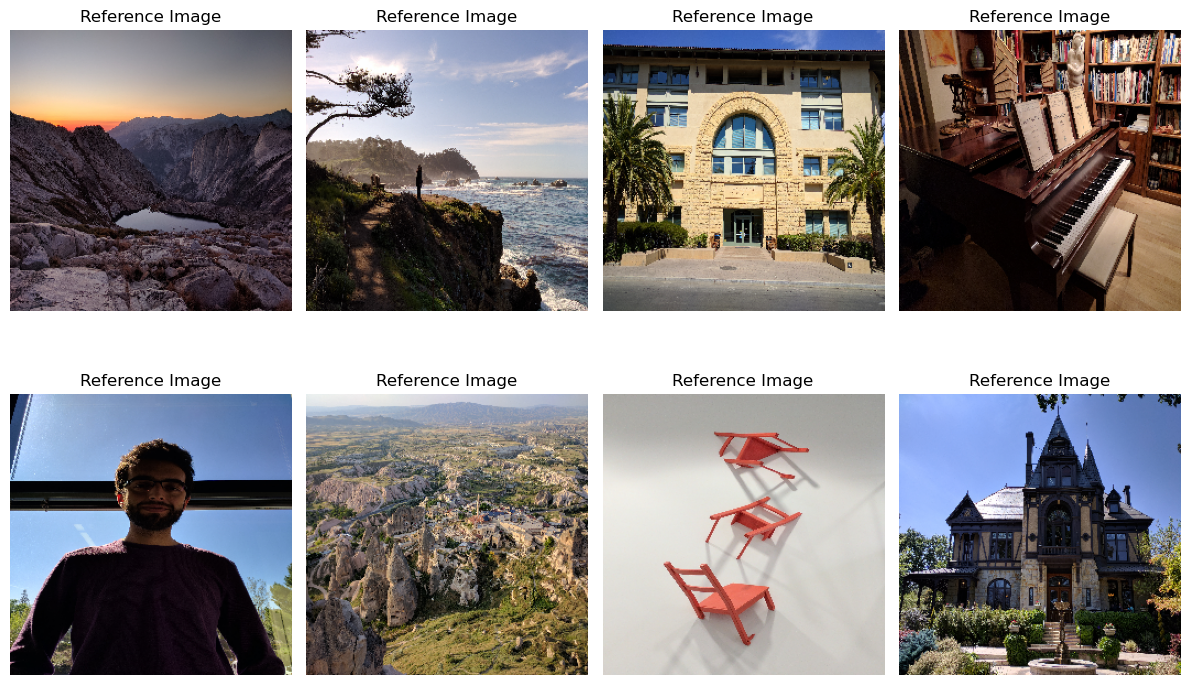

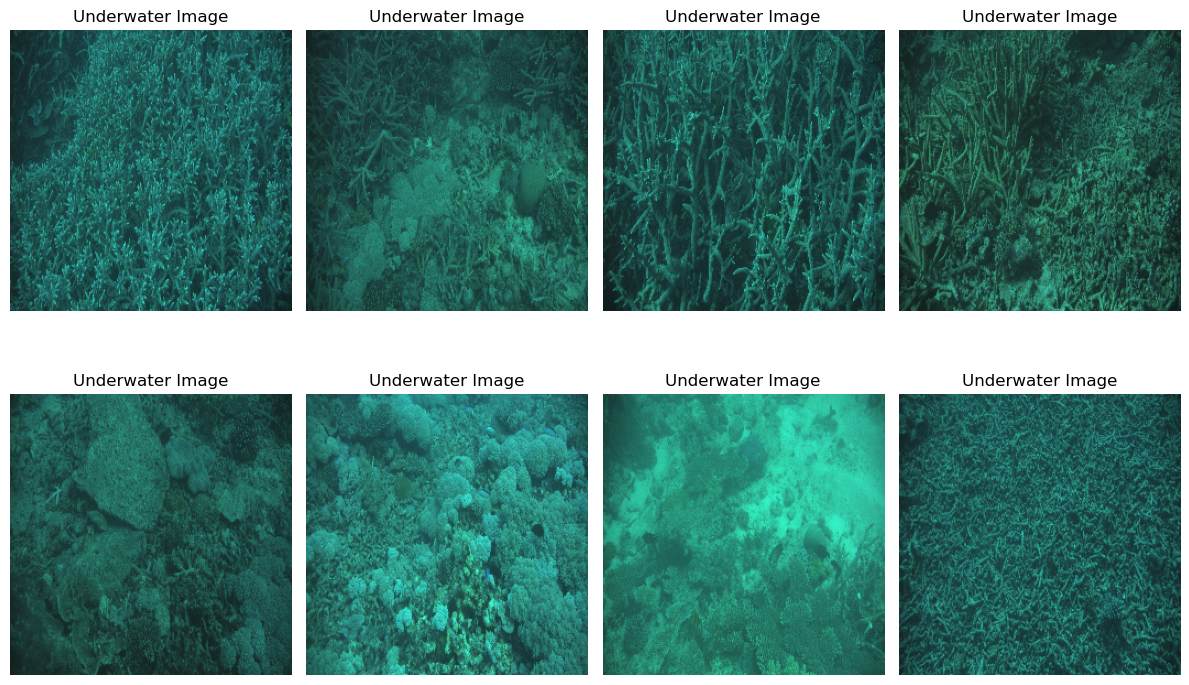

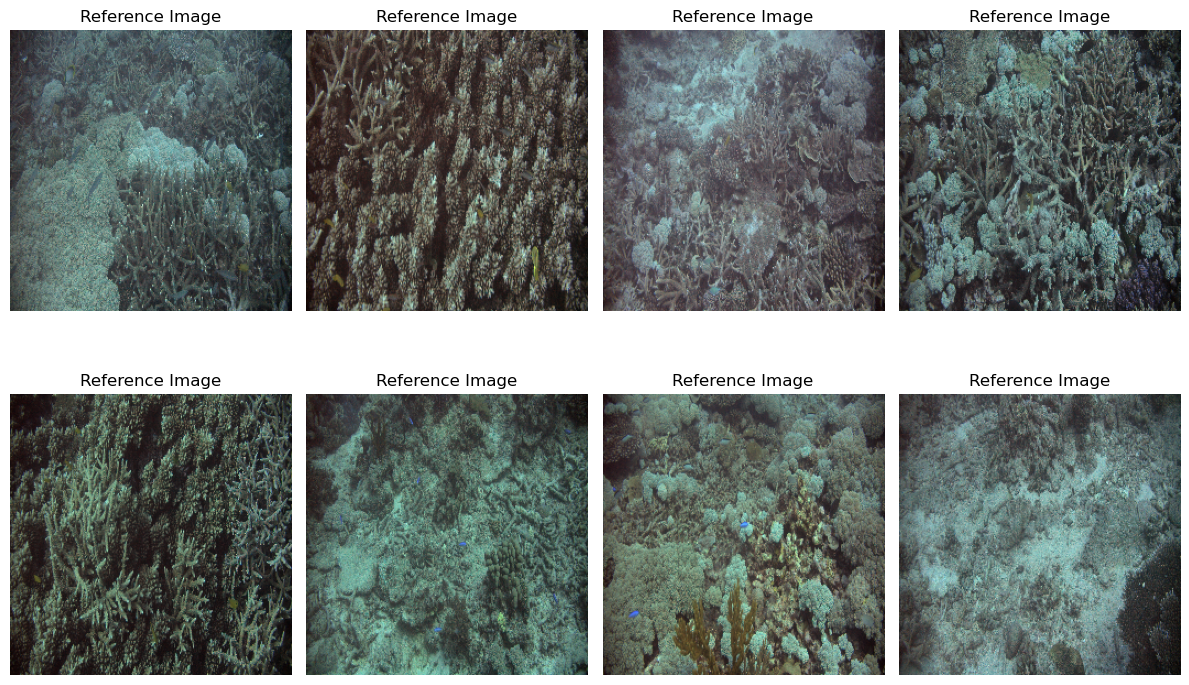

In [6]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utils.utils import Atmospheric_Dataset, Underwater_Dataset



# Função para plotar imagens em formato de grid
def plot_images_grid(images, titles=None, rows=2, cols=4):
    if titles is None:
        titles = [''] * len(images)
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()  # Achata a matriz de eixos para fácil indexação
    
    for i, (img, title) in enumerate(zip(images, titles)):
        ax = axes[i]
        ax.imshow(img.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
        ax.set_title(title)
        ax.axis('off')
    
    # Remove eixos não usados, caso haja algum espaço extra
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# Definir uma transformação simples para o carregamento das imagens
transform = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])

# Configurar datasets e dataloaders
atmospheric_dataset = Atmospheric_Dataset(
    atmospheric_dataset_name="HDR+", batch_size=8, transforms=transform, task="train", supervised=True
)
underwater_dataset = Underwater_Dataset(
    underwater_dataset_name="HICRD", transforms=transform, task="train", supervised=True
)

# Carregar o primeiro batch de cada dataset
atmospheric_dataloader = DataLoader(atmospheric_dataset, batch_size=8, shuffle=True)
underwater_dataloader = DataLoader(underwater_dataset, batch_size=8, shuffle=True)

# Pegar o primeiro batch
atmospheric_batch = next(iter(atmospheric_dataloader))
underwater_batch = next(iter(underwater_dataloader))

# Plotar shapes
print(f"Atmospheric batch shape: {atmospheric_batch[0].shape}, {atmospheric_batch[1].shape}")
print(f"Underwater batch shape: {underwater_batch[0].shape}, {underwater_batch[1].shape}")

# Plotar as imagens (exibe apenas o primeiro batch, com 8 imagens no total para cada dataset)
plot_images_grid(atmospheric_batch[0], titles=["Atmospheric Image"]*8, rows=2, cols=4)
plot_images_grid(atmospheric_batch[1], titles=["Reference Image"]*8, rows=2, cols=4)

plot_images_grid(underwater_batch[0], titles=["Underwater Image"]*8, rows=2, cols=4)
plot_images_grid(underwater_batch[1], titles=["Reference Image"]*8, rows=2, cols=4)



In [ ]:
 python Main.py --wandb True--pretrained_path "/output/ckpt/'ckpt_800_Enhancement Training (Charbonnier + Angular Color Loss + MS SSIM).pt'